[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NU-MSE-LECTURES/465_Computational_Microscopy_2026/blob/dev/Week_04/code_examples/example_06_data_augmentation.ipynb)

# Example 06: Data Augmentation Techniques

## Overview
Data augmentation is a crucial technique for improving deep learning model performance by artificially expanding the training dataset. This notebook demonstrates various augmentation methods without training any model.

## Why Data Augmentation?
1. **Increases Dataset Size**: Virtual expansion of training data
2. **Improves Generalization**: Model sees variations during training
3. **Prevents Overfitting**: Reduces reliance on specific training samples
4. **Simulates Real Conditions**: Accounts for variations in data collection
5. **Cost-Effective**: No need to collect more labeled data

## Common Augmentation Techniques
- **Geometric**: Rotation, flip, shift, zoom, shear
- **Photometric**: Brightness, contrast, saturation, hue
- **Noise**: Gaussian noise, salt-and-pepper noise
- **Advanced**: Mixup, CutMix, RandAugment

## Learning Objectives
- Understand different augmentation techniques
- Visualize augmented images
- Compare augmentation strategies
- Learn when to use different augmentation methods

---

## Part 1: Setup and Install Required Libraries

In [15]:
# Install required packages
import subprocess
import sys

try:
    import tensorflow
    print("TensorFlow already installed")
except ImportError:
    print("Installing TensorFlow...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "tensorflow"])
    print("TensorFlow installed successfully")

# Check if running in Colab
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab.")
except ImportError:
    IN_COLAB = False
    print("Running locally.")

TensorFlow already installed
Running locally.


In [3]:
# Import all required libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from pathlib import Path
import io
from PIL import Image
import urllib.request

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image processing
from scipy import ndimage
try:
    import cv2
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "opencv-python"])
    import cv2

# Visualization
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 10
sns.set_style('whitegrid')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)
print("All libraries imported successfully!")

TensorFlow version: 2.20.0
NumPy version: 2.2.6
All libraries imported successfully!


---

## Part 2: Create Sample Dataset

We'll create synthetic images and download a few real images to demonstrate augmentation.

Loading sample images from CIFAR-10 dataset...
Sample images shape: (3, 224, 224, 3)
Image dtype: uint8
Image value range: [0, 255]
Image labels: ['frog', 'deer', 'deer']


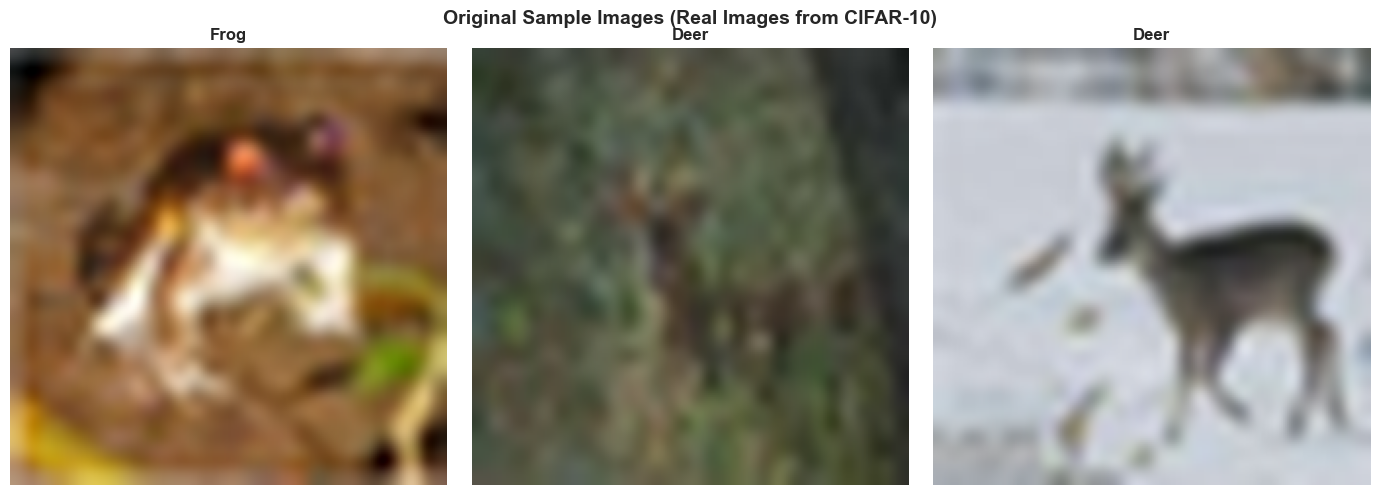

In [4]:
# Load sample images from TensorFlow datasets
def load_sample_images():
    """
    Load real sample images from TensorFlow/Keras datasets.
    Uses CIFAR-10 dataset which contains diverse natural images.
    """
    # Load CIFAR-10 dataset (small, real images)
    (x_train, y_train), _ = keras.datasets.cifar10.load_data()
    
    # Get diverse class examples (airplane, automobile, bird)
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    
    # Select images from different classes for variety
    selected_indices = [0, 10, 20]  # Different classes
    images = x_train[selected_indices]
    
    # Resize to 224x224 for better visualization
    images_resized = []
    for img in images:
        img_pil = Image.fromarray(img)
        img_resized = img_pil.resize((224, 224), Image.Resampling.LANCZOS)
        images_resized.append(np.array(img_resized))
    
    images = np.array(images_resized)
    labels = [class_names[int(y_train[idx][0])] for idx in selected_indices]
    
    return images, labels

# Load sample images
print("Loading sample images from CIFAR-10 dataset...")
sample_images, image_labels = load_sample_images()

print(f"Sample images shape: {sample_images.shape}")
print(f"Image dtype: {sample_images.dtype}")
print(f"Image value range: [{sample_images.min()}, {sample_images.max()}]")
print(f"Image labels: {image_labels}")

# Display original images
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
fig.suptitle('Original Sample Images (Real Images from CIFAR-10)', fontsize=14, fontweight='bold')

for idx, (ax, label) in enumerate(zip(axes, image_labels)):
    ax.imshow(sample_images[idx])
    ax.set_title(f'{label.title()}', fontsize=12, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()


---

## Part 3: Geometric Augmentation Techniques

These augmentations transform the spatial layout of images.

Applied 5 geometric augmentation techniques


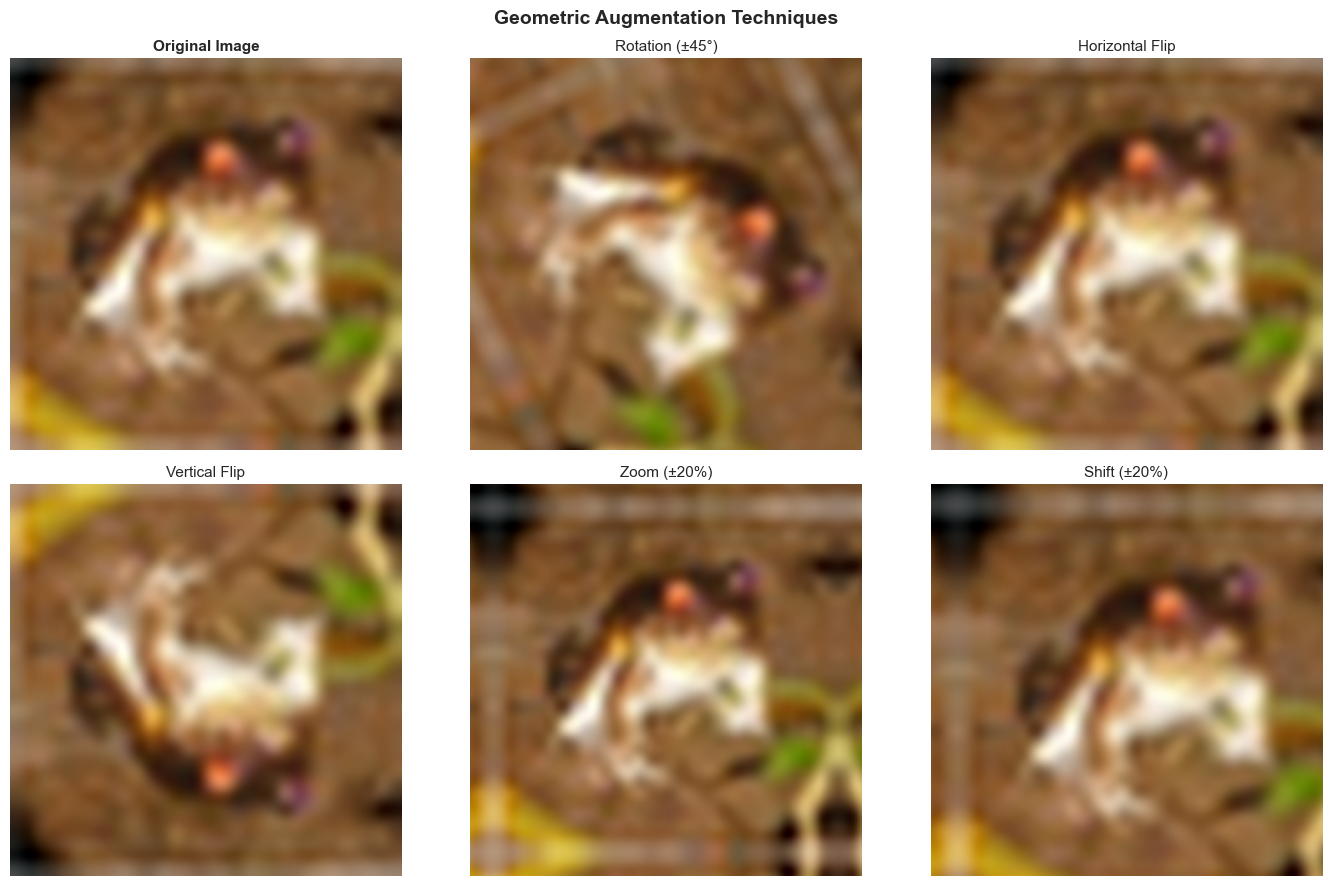

In [25]:
# Create geometric augmentation pipeline using Keras layers
def apply_geometric_augmentations(images):
    """
    Apply various geometric augmentations to images.
    """
    # Normalize images to [0, 1] for augmentation
    images_normalized = images.astype(np.float32) / 255.0
    
    augmentations = {}
    
    # 1. Rotation (±45 degrees)
    rotation_layer = keras.layers.RandomRotation(0.25)  # 0.25 * 180 = 45 degrees
    augmentations['Rotation (±45°)'] = rotation_layer(images_normalized, training=True)
    
    # 2. Horizontal Flip
    flip_layer = keras.layers.RandomFlip("horizontal")
    augmentations['Horizontal Flip'] = flip_layer(images_normalized, training=True)
    
    # 3. Vertical Flip
    vflip_layer = keras.layers.RandomFlip("vertical")
    augmentations['Vertical Flip'] = vflip_layer(images_normalized, training=True)
    
    # 4. Zoom (Random zoom from 80% to 120%)
    zoom_layer = keras.layers.RandomZoom(0.2)  # ±20% zoom
    augmentations['Zoom (±20%)'] = zoom_layer(images_normalized, training=True)
    
    # 5. Translation (Shift)
    translate_layer = keras.layers.RandomTranslation(0.2, 0.2)  # ±20% shift
    augmentations['Shift (±20%)'] = translate_layer(images_normalized, training=True)
    
    # Convert back to uint8 for display
    for key in augmentations:
        augmentations[key] = (augmentations[key].numpy() * 255).astype(np.uint8)
    
    return augmentations

# Apply augmentations to first image
geo_augmentations = apply_geometric_augmentations(sample_images[0:1])

print(f"Applied {len(geo_augmentations)} geometric augmentation techniques")

# Visualize geometric augmentations
fig, axes = plt.subplots(2, 3, figsize=(14, 9))
fig.suptitle('Geometric Augmentation Techniques', fontsize=14, fontweight='bold')

# Original
axes[0, 0].imshow(sample_images[0])
axes[0, 0].set_title('Original Image', fontsize=11, fontweight='bold')
axes[0, 0].axis('off')

# Augmented images
aug_names = list(geo_augmentations.keys())
positions = [(0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

for (row, col), aug_name in zip(positions, aug_names):
    axes[row, col].imshow(geo_augmentations[aug_name][0])
    axes[row, col].set_title(aug_name, fontsize=11)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

---

## Part 4: Photometric Augmentation Techniques

These augmentations modify pixel values (brightness, contrast, color, etc.).

Applied 4 photometric augmentation techniques


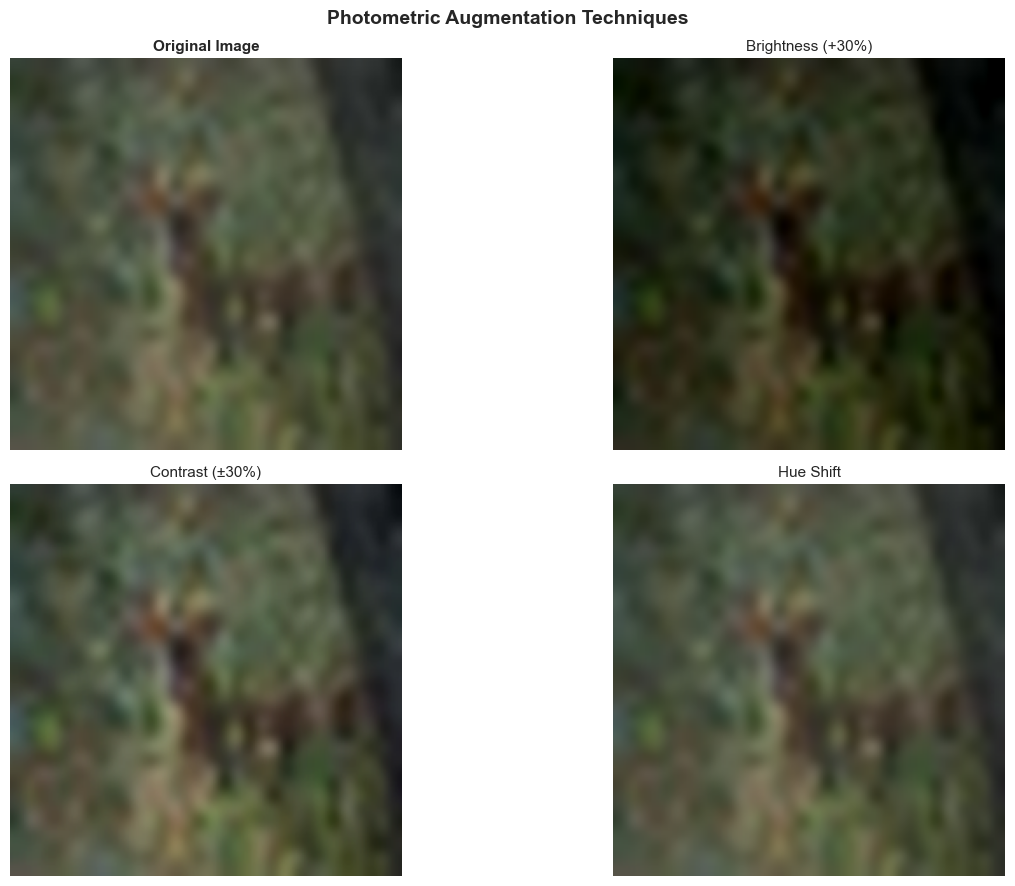

In [14]:
def apply_photometric_augmentations(images):
    """
    Apply various photometric augmentations to images.
    Returns a dict of uint8 images (N,H,W,C) clipped to [0,255].
    """
    images = np.asarray(images)
    if images.ndim == 3:
        images = images[None, ...]  # make batch

    # Normalize to [0,1]
    images_normalized = images.astype(np.float32) / 255.0
    images_tf = tf.convert_to_tensor(images_normalized, dtype=tf.float32)

    augmentations_tf = {}

    # 1. Brightness Adjustment (random delta in ±30%)
    delta_b = float(np.random.uniform(-0.3, 0.3))
    augmentations_tf['Brightness (+30%)'] = tf.image.adjust_brightness(images_tf, delta_b)

    # 2. Contrast Adjustment (random factor ~0.7-1.3)
    contrast_factor = float(np.random.uniform(0.7, 1.3))
    augmentations_tf['Contrast (±30%)'] = tf.image.adjust_contrast(images_tf, contrast_factor)

    # 3. Hue Shift (small delta)
    delta_h = float(np.random.uniform(-0.08, 0.08))
    try:
        augmentations_tf['Hue Shift'] = tf.image.adjust_hue(images_tf, delta_h)
    except Exception:
        augmentations_tf['Hue Shift'] = augmentations_tf['Contrast (±30%)']

    # 4. Desaturated (blend with grayscale)
    gray = tf.image.rgb_to_grayscale(images_tf)  # (N,H,W,1)
    gray_rgb = tf.concat([gray, gray, gray], axis=-1)
    augmentations_tf['Desaturated'] = 0.5 * images_tf + 0.5 * gray_rgb

    # Convert TF tensors to uint8 numpy arrays, clamped to [0,1]
    augmentations = {}
    for k, v in augmentations_tf.items():
        arr = v.numpy() if hasattr(v, 'numpy') else np.array(v)
        arr = np.clip(arr, 0.0, 1.0)
        augmentations[k] = (arr * 255.0).astype(np.uint8)

    return augmentations

# Apply photometric augmentations
photo_augmentations = apply_photometric_augmentations(sample_images[1:2])

print(f"Applied {len(photo_augmentations)} photometric augmentation techniques")

# Visualize photometric augmentations
fig, axes = plt.subplots(2, 2, figsize=(14, 9))
fig.suptitle('Photometric Augmentation Techniques', fontsize=14, fontweight='bold')

# Original
axes[0, 0].imshow(sample_images[1])
axes[0, 0].set_title('Original Image', fontsize=11, fontweight='bold')
axes[0, 0].axis('off')

# Augmented images
aug_names = list(photo_augmentations.keys())
positions = [(0, 1), (1, 0), (1, 1)]

for (row, col), aug_name in zip(positions, aug_names):
    axes[row, col].imshow(photo_augmentations[aug_name][0])
    axes[row, col].set_title(aug_name, fontsize=11)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

---

## Part 5: Advanced Augmentation Techniques

These are more sophisticated augmentation methods that combine multiple transformations or use advanced strategies.

Applied 5 advanced augmentation techniques


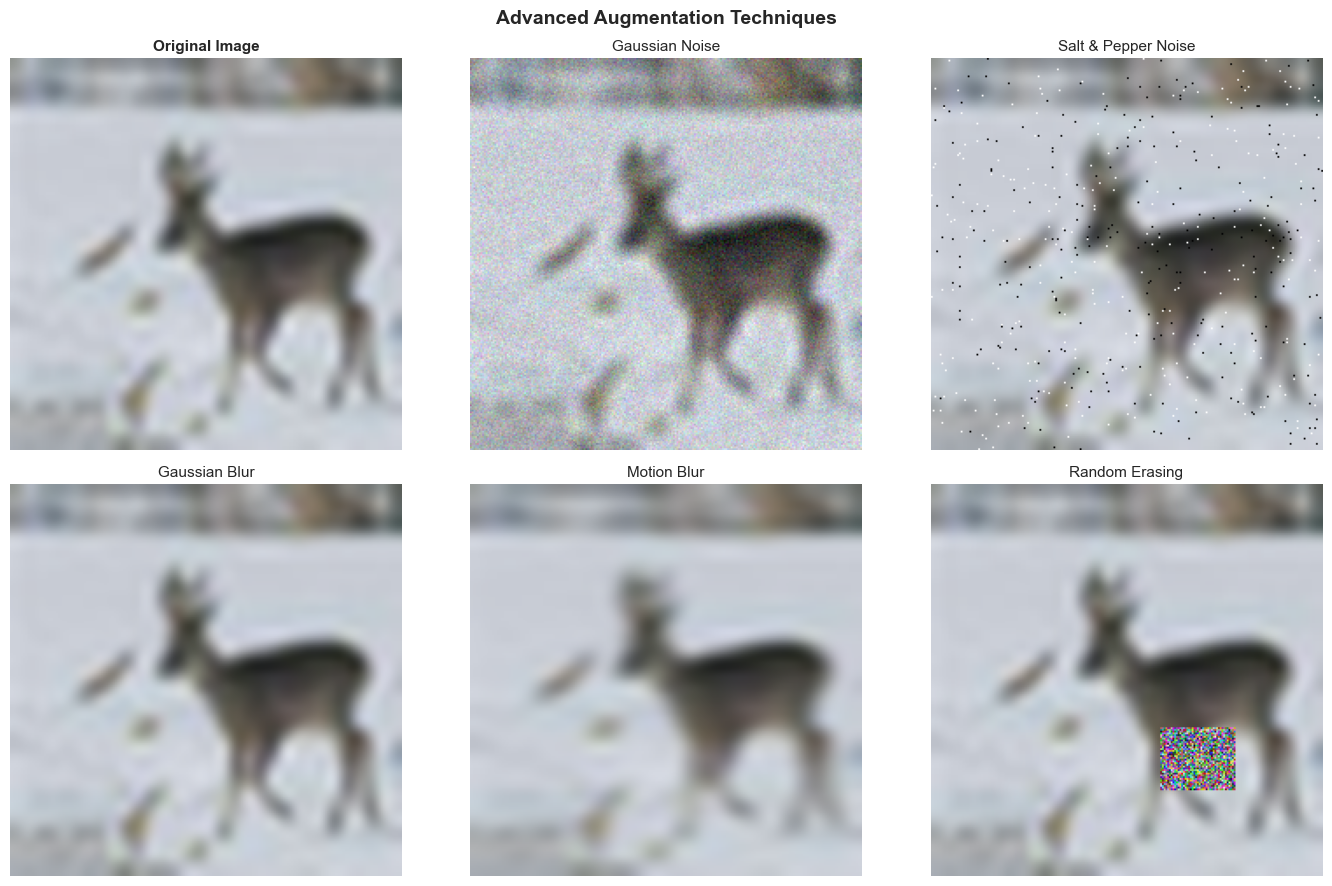

In [5]:
def apply_advanced_augmentations(images):
    """
    Apply advanced augmentation techniques to a single image (accepts a batch or single image).
    Returns a dict of augmentations (uint8 images).
    """
    # Accept either (H,W,C) or (N,H,W,C)
    if images.ndim == 4:
        img = images[0]
    else:
        img = images

    img_uint8 = img.astype(np.uint8)
    h, w = img_uint8.shape[:2]

    augmentations = {}

    # 1. Gaussian Noise
    img_noisy = np.clip(
        img_uint8.astype(np.float32) + np.random.normal(0, 15, (h, w, 3)),
        0, 255
    ).astype(np.uint8)
    augmentations['Gaussian Noise'] = img_noisy

    # 2. Salt and Pepper Noise (safe pixel-wise)
    img_sp = img_uint8.copy()
    num_salt = int(0.005 * h * w)
    num_pepper = int(0.005 * h * w)
    for _ in range(num_salt):
        i = np.random.randint(0, h)
        j = np.random.randint(0, w)
        img_sp[i, j] = 255
    for _ in range(num_pepper):
        i = np.random.randint(0, h)
        j = np.random.randint(0, w)
        img_sp[i, j] = 0
    augmentations['Salt & Pepper Noise'] = img_sp

    # 3. Gaussian Blur
    img_blur = cv2.GaussianBlur(img_uint8, (5, 5), 0)
    augmentations['Gaussian Blur'] = img_blur

    # 4. Motion Blur (directional kernel)
    size = 15
    kernel = np.zeros((size, size), dtype=np.float32)
    kernel[int((size - 1) / 2), :] = np.ones(size, dtype=np.float32)
    kernel = kernel / kernel.sum()
    img_motion = cv2.filter2D(img_uint8, -1, kernel)
    augmentations['Motion Blur'] = img_motion

    # 5. Random Erasing (robust bounds)
    img_dropout = img_uint8.copy()
    erase_h = np.random.randint(max(1, h // 10), max(2, h // 4))
    erase_w = np.random.randint(max(1, w // 10), max(2, w // 4))
    y = np.random.randint(0, h - erase_h + 1)
    x = np.random.randint(0, w - erase_w + 1)
    random_color = np.random.randint(0, 256, (erase_h, erase_w, 3), dtype=np.uint8)
    img_dropout[y:y + erase_h, x:x + erase_w] = random_color
    augmentations['Random Erasing'] = img_dropout

    return augmentations


# Apply advanced augmentations to a single sample
adv_augmentations = apply_advanced_augmentations(sample_images[2:3])

print(f"Applied {len(adv_augmentations)} advanced augmentation techniques")

# Visualize advanced augmentations
fig, axes = plt.subplots(2, 3, figsize=(14, 9))
fig.suptitle('Advanced Augmentation Techniques', fontsize=14, fontweight='bold')

# Original
axes[0, 0].imshow(sample_images[2])
axes[0, 0].set_title('Original Image', fontsize=11, fontweight='bold')
axes[0, 0].axis('off')

# Augmented images
aug_names = list(adv_augmentations.keys())
positions = [(0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

for (row, col), aug_name in zip(positions, aug_names):
    axes[row, col].imshow(adv_augmentations[aug_name])
    axes[row, col].set_title(aug_name, fontsize=11)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


---

## Part 6: Augmentation Pipeline - Multiple Augmentations at Once

In practice, we often combine multiple augmentations into a single pipeline.

Augmentation Pipeline:
  - random_rotation_1
  - random_flip_1
  - random_zoom_1
  - random_translation_1
  - lambda
  - lambda_1

Generated 9 augmented versions of a single image


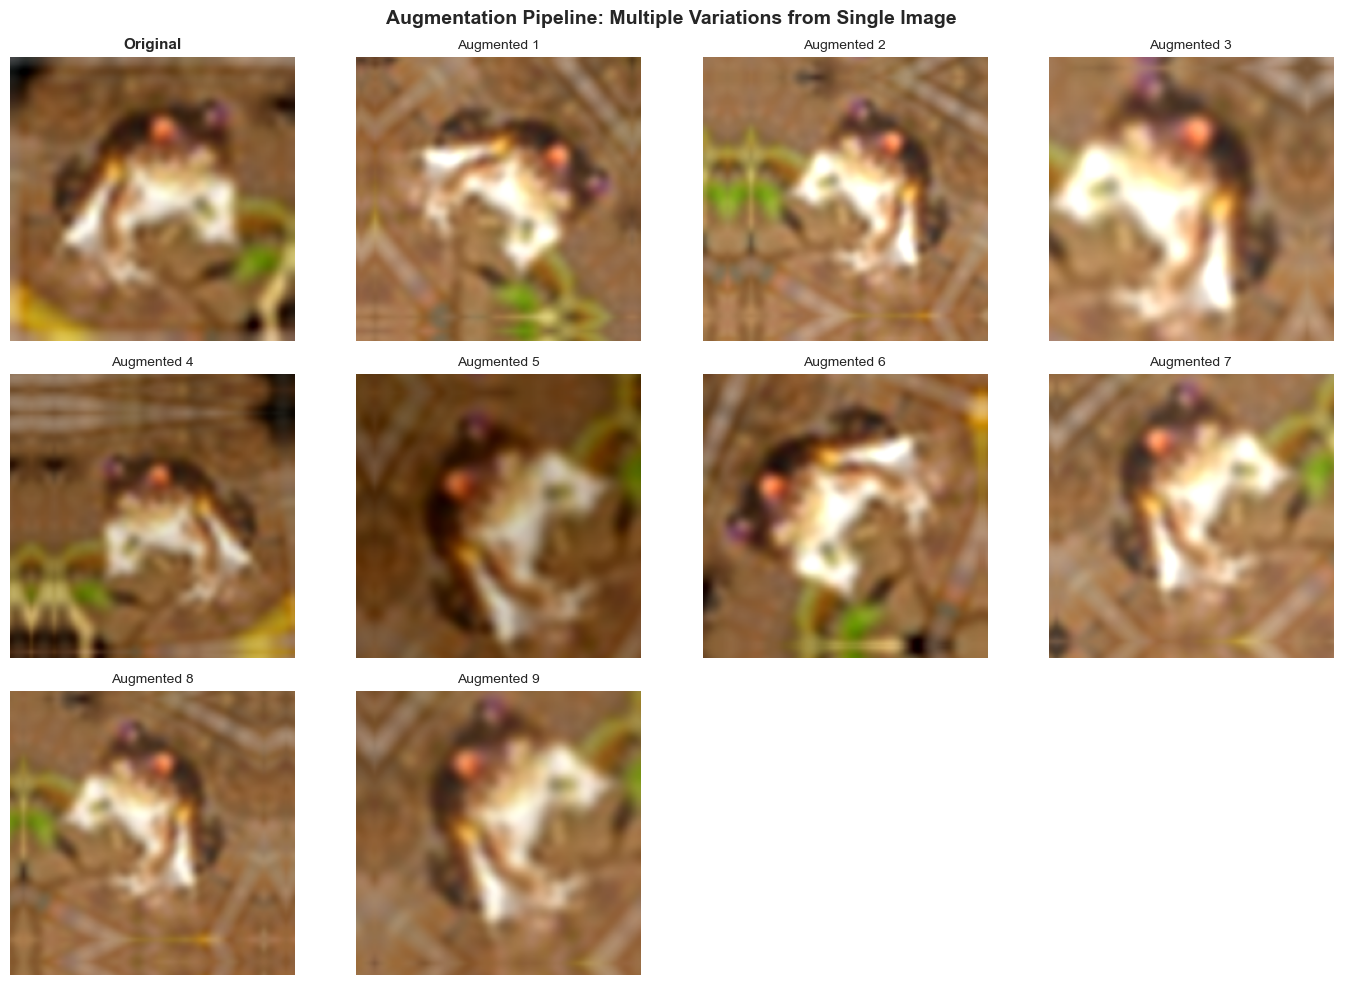

In [15]:
# Create a comprehensive augmentation pipeline
def create_augmentation_pipeline():
    """
    Create a comprehensive augmentation pipeline combining multiple techniques.
    """
    pipeline = keras.Sequential([
        keras.layers.RandomRotation(0.2),
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomZoom(0.2),
        keras.layers.RandomTranslation(0.1, 0.1),
        # Brightness using tf.image with random delta
        keras.layers.Lambda(lambda x: tf.image.adjust_brightness(x, tf.random.uniform([], -0.2, 0.2))),
        # Contrast using tf.image with random factor
        keras.layers.Lambda(lambda x: tf.image.adjust_contrast(x, tf.random.uniform([], 0.8, 1.2))),
    ], name="AugmentationPipeline")
    
    return pipeline

# Create and apply pipeline
augmentation_pipeline = create_augmentation_pipeline()
print("Augmentation Pipeline:")
for layer in augmentation_pipeline.layers:
    print(f"  - {layer.name}")

# Apply pipeline to original images (normalized)
sample_normalized = sample_images.astype(np.float32) / 255.0

# Generate multiple augmented versions
n_augmented = 9
augmented_batch = []

for _ in range(n_augmented):
    aug_img = augmentation_pipeline(sample_normalized[0:1], training=True)
    # ensure values clipped to [0,1] before scaling
    img_np = np.clip(aug_img.numpy()[0], 0.0, 1.0)
    augmented_batch.append((img_np * 255).astype(np.uint8))

print(f"\nGenerated {n_augmented} augmented versions of a single image")

# Visualize augmentation pipeline results
fig, axes = plt.subplots(3, 4, figsize=(14, 10))
fig.suptitle('Augmentation Pipeline: Multiple Variations from Single Image', 
             fontsize=14, fontweight='bold')

# Original in first position
axes[0, 0].imshow(sample_images[0])
axes[0, 0].set_title('Original', fontsize=11, fontweight='bold')
axes[0, 0].axis('off')

# Augmented versions
for idx, aug_img in enumerate(augmented_batch):
    row = (idx + 1) // 4
    col = (idx + 1) % 4
    axes[row, col].imshow(aug_img)
    axes[row, col].set_title(f'Augmented {idx+1}', fontsize=10)
    axes[row, col].axis('off')

# Hide unused subplots
for idx in range(n_augmented + 1, 12):
    axes[idx // 4, idx % 4].axis('off')

plt.tight_layout()
plt.show()

---

## Part 7: Best Practices and Guidelines

When using data augmentation, keep these best practices in mind.

In [7]:
# Display best practices and guidelines
print("\n" + "="*80)
print("DATA AUGMENTATION: BEST PRACTICES AND GUIDELINES")
print("="*80 + "\n")

best_practices = {
    "1. Domain-Specific Augmentation": [
        "• Use augmentations that make sense for your domain",
        "• Example: Don't flip medical X-rays upside down",
        "• Microscopy: Consider realistic variations in the data"
    ],
    "2. Dataset Size Matters": [
        "• Small datasets (< 1000): Use aggressive augmentation",
        "• Medium datasets (1000-10000): Use moderate augmentation",
        "• Large datasets (> 10000): Use light augmentation"
    ],
    "3. Augmentation Strength": [
        "• Too weak: Minimal benefit, model learns slowly",
        "• Too strong: Model gets confused, learns irrelevant patterns",
        "• Balanced: Data looks realistic but varied"
    ],
    "4. Train vs. Test": [
        "• ALWAYS apply augmentation only during training",
        "• Test/validation: Use original, unaugmented data",
        "• This ensures fair evaluation of model performance"
    ],
    "5. Specific Technique Guidelines": [
        "• Rotation: Use sparingly if orientation matters",
        "• Flip: Avoid if mirror image is unrealistic",
        "• Color/Brightness: Safe for most RGB images",
        "• Blur: Use carefully, might hide important details",
        "• Noise: Add realistically (amount should match real data noise)"
    ],
    "6. Microscopy-Specific Considerations": [
        "• Preserve scale relationships in particle/cell segmentation",
        "• Add realistic noise based on microscope characteristics",
        "• Consider illumination variations",
        "• Preserve phase/chemical information for phase-dependent techniques"
    ],
    "7. Monitoring and Validation": [
        "• Visualize augmented images - do they look realistic?",
        "• Compare model performance with/without augmentation",
        "• Use validation set without augmentation",
        "• Check if augmentation improves generalization"
    ],
    "8. Common Mistakes to Avoid": [
        "• ❌ Applying augmentation to test set",
        "• ❌ Using unrealistic augmentations for your domain",
        "• ❌ Over-augmentation that makes data unrecognizable",
        "• ❌ Forgetting to normalize data before augmentation",
        "• ❌ Not visualizing augmented samples"
    ]
}

for category, guidelines in best_practices.items():
    print(f"\n{category}")
    print("-" * 80)
    for guideline in guidelines:
        print(guideline)

print("\n" + "="*80)


DATA AUGMENTATION: BEST PRACTICES AND GUIDELINES


1. Domain-Specific Augmentation
--------------------------------------------------------------------------------
• Use augmentations that make sense for your domain
• Example: Don't flip medical X-rays upside down
• Microscopy: Consider realistic variations in the data

2. Dataset Size Matters
--------------------------------------------------------------------------------
• Small datasets (< 1000): Use aggressive augmentation
• Medium datasets (1000-10000): Use moderate augmentation
• Large datasets (> 10000): Use light augmentation

3. Augmentation Strength
--------------------------------------------------------------------------------
• Too weak: Minimal benefit, model learns slowly
• Too strong: Model gets confused, learns irrelevant patterns
• Balanced: Data looks realistic but varied

4. Train vs. Test
--------------------------------------------------------------------------------
• ALWAYS apply augmentation only during traini

---

## Summary

### What We Learned:
1. **Geometric Augmentation**: Rotation, flip, zoom, shift
2. **Photometric Augmentation**: Brightness, contrast, desaturation
3. **Advanced Techniques**: Noise, blur, elastic deformation, random erasing
4. **Augmentation Pipelines**: Combining multiple techniques
5. **Strategy Selection**: Light, moderate, aggressive based on dataset size
6. **Best Practices**: Domain-specific, train-only, realistic augmentation

### Key Takeaways:
- Data augmentation artificially expands training datasets
- Use realistic augmentations appropriate for your domain
- Only augment training data, not test/validation data
- Visualize augmented samples to ensure they're realistic
- Balance augmentation strength with dataset size
- Different tasks and domains require different strategies

### Next Steps:
- Integrate augmentation into your training pipelines
- Experiment with different strategies for your specific task
- Monitor how augmentation affects model generalization
- Create domain-specific augmentation for microscopy images